# Beta Bank Customer Retention

### Beta Bank is losing customers every month. They also realize that maintaining their current client base is more valuable than replacing them with new customers. Given the data provided by Beta Bank, we are going to identify which customers are most at risk of leaving.

In [ ]:
#!pip install scikit-learn
#!pip install joblib
#!pip install matplotlib

In [2]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression 
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [3]:
url = 'https://code.s3.yandex.net/datasets/Churn.csv'
df = pd.read_csv(url)

In [4]:
display(df.info())  
display(df.describe()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
# count for any duplicates
num_duplicates = df.duplicated().sum()
# print number of duplicate rows 
print(f"duplicate rows: {num_duplicates}")

# check for duplicate customer id
duplicates = df['CustomerId'].duplicated().sum()
print(f'customer id duplicates: {duplicates}')

duplicate rows: 0
customer id duplicates: 0


In [6]:
# standardize column names
df.columns = df.columns.str.lower()
# ignore missing values from tenure
df['tenure'] = df['tenure'].fillna(df['tenure'].median()).astype('Int64') 
# Reset the index 
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           10000 non-null  Int64  
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: Int64(1), float64(2), int64(8), object(3)
memory usage: 1.1+ MB
None


### Mean and median values for the tenure column both equal to about 5, so filling in any of the missing values from this column with the median score shouldn't schew our results.  

# Model Data

In [7]:
# One-Hot Encode the 'gender' column 
df = pd.get_dummies(df, columns=['gender'], drop_first=True)
print("Column names before encoding:", df.columns)
# Apply Ordinal Encoding to the 'geography' column
encoder = OrdinalEncoder() 
df['geography_encoded'] = encoder.fit_transform(df[['geography']])

Column names before encoding: Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography', 'age',
       'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember',
       'estimatedsalary', 'exited', 'gender_Male'],
      dtype='object')


### We applied One-Hot Encoding to our binary variables for gender. Then Label Encoding for geography since these data fields contain multiple categories of equal precedence.

In [ ]:
# define the target and features
target = df['exited']
features = df.drop('exited', axis=1)

# list variables 
features = features[['geography_encoded']]

# split the data into training and validation
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

# training data
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

# confusion matrix
conf_matrix = confusion_matrix(target_valid, predicted_valid)

print(conf_matrix)

[[1965    0]
 [ 535    0]]


In [ ]:
# define the target and features
target = df['exited']
features = df.drop('exited', axis=1)

# list variables 
features = features[['age', 'creditscore']]

# split the data into training and validation
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

# training data
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

# confusion matrix
conf_matrix = confusion_matrix(target_valid, predicted_valid)

print(conf_matrix)

[[1676  289]
 [ 371  164]]


### We iterated through different variables using confusion matrix to see if any of our data fields might imbalance our results. 

In [ ]:
# label dependent and independent variables 
target = df['exited']
features = df[['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard', 'gender_Male', 'isactivemember', 'estimatedsalary']]

# split the data into training and validation
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

# downsample function
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

# training data
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)


predicted_valid = model.predict(features_valid)

# F1 score
f1 = f1_score(target_valid, predicted_valid)

print('F1:', f1)


F1: 0.380080556572684


### In our first attempt to model the data, we used Logistic Regression and included most independent variables, specifically excluding those assigned at random.

In [11]:
# label dependent and independent variables 
target = df['exited']
features = df[['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard', 'gender_Male', 'isactivemember', 'estimatedsalary']]

# split the data into training and validation
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

# downsample function
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

# training data
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)
model = LogisticRegression(random_state=12345, class_weight='balanced', solver='liblinear')
model.fit(features_downsampled, target_downsampled)

predicted_valid = model.predict(features_valid)

# F1 score
f1 = f1_score(target_valid, predicted_valid)

print('F1:', f1)

F1: 0.48792884371029227


### The only chnage from our first attempt was adding class_weight='balanced'

In [12]:
# label dependent and independent variables 
target = df['exited']
features = df[['age', 'creditscore', 'numofproducts', 'hascrcard', 'gender_Male', 'isactivemember', 'estimatedsalary', 'geography_encoded', 'balance', 'tenure']]

# split the data into training and validation
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.23, random_state=12345)

# downsample function
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

# training data
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)
model = RandomForestClassifier(max_depth=6, n_estimators=92, random_state=12345, class_weight='balanced')
model.fit(features_downsampled, target_downsampled)

predicted_valid = model.predict(features_valid)

# F1 score
f1 = f1_score(target_valid, predicted_valid)

print('F1:', f1)

# calculate AUC-ROC values
predicted_prob_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, predicted_prob_valid)

print('AUC-ROC:', auc_roc)


F1: 0.6032
AUC-ROC: 0.8552790394106289


### We made numerous minor adjustments to our code to get as close to 60 as possible. We added the encoded variable of geography, and adjusted our hyperparameters to a max depth of 6 with n_estimators to 92.  Switched to Random Forest Classifier model. Finally, increasing our training data set to 77 pushed us over the line.

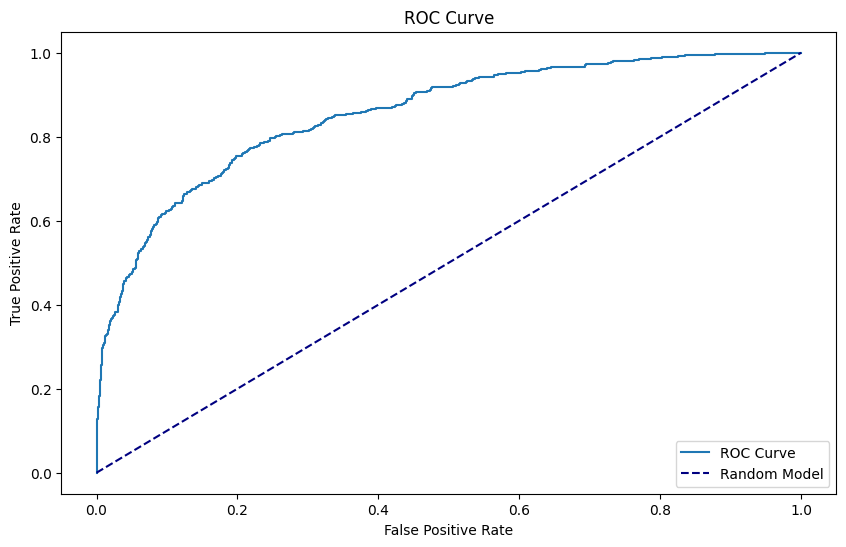

In [13]:
# calculate the ROC curve
fpr, tpr, _ = roc_curve(target_valid, predicted_prob_valid)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Due to the variability of the data, we ended up with a moderate F1 score of 0.6, indicating that no single set of features was highly accurate in predicting whether a customer might close their accounts and leave Beta Bank. However we managed to handle the classification imbalance significantly better than a random model, achieving an AUC-ROC of 0.86. While our model won't perfectly predict every customer who may be considering leaving Beta Bank, it represents the best possible performance given the data available. This information proves invaluable for the customer outreach team to not only slow customer loss, but also to once again grow Beta Bank's business.

All project files are available at Github : https://github.com/Tom-Kinstle/sprint_8